In [9]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import Logit, WLS  # Use WLS instead of OLS
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score


In [11]:
# ## Step 1: Setup and Data Loading

# Create directories to save results
trial_pp_dir = os.path.join(os.getcwd(), "trial_pp")
trial_itt_dir = os.path.join(os.getcwd(), "trial_itt")
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

data_censored = pd.read_csv("data_censored.csv")
print("Columns in dataset:", data_censored.columns.tolist())

Columns in dataset: ['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'censored', 'eligible']


In [3]:
# ## Step 2: Data Cleaning and Preprocessing
# Clean column names and drop missing values
data_censored.columns = data_censored.columns.str.strip()
data_censored.dropna(inplace=True)

# Standardize numerical columns for stability
scaler = StandardScaler()
data_censored[['age', 'x1', 'x3']] = scaler.fit_transform(data_censored[['age', 'x1', 'x3']])


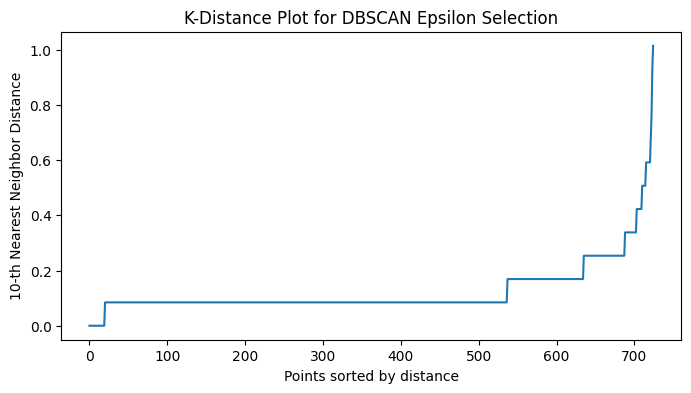

Number of clusters found: 4


In [4]:
# ## Step 3: DBSCAN Clustering
# Function to determine the optimal epsilon value
def plot_k_distance(data, k=10):
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances[:, k-1])
    
    plt.figure(figsize=(8,4))
    plt.plot(distances)
    plt.xlabel("Points sorted by distance")
    plt.ylabel(f"{k}-th Nearest Neighbor Distance")
    plt.title("K-Distance Plot for DBSCAN Epsilon Selection")
    plt.show()

# Plot k-distance using selected features
plot_k_distance(data_censored[['age', 'x1', 'x3']], k=10)

# Apply DBSCAN Clustering
dbscan = DBSCAN(eps=0.7, min_samples=10)
data_censored['cluster'] = dbscan.fit_predict(data_censored[['age', 'x1', 'x3']])
n_clusters = len(set(data_censored['cluster'])) - (1 if -1 in data_censored['cluster'] else 0)
print("Number of clusters found:", n_clusters)

In [5]:
# ## Step 4: Compute IPCW Weights
# Function to calculate inverse probability of censoring weights
def calculate_weights(data, treatment_col):
    data = data.copy()
    data['ipcw_weight'] = np.nan  # Initialize column for weights

    for cluster in data['cluster'].unique():
        cluster_data = data[data['cluster'] == cluster]
        if len(cluster_data) < 5:
            continue
        try:
            model = LogisticRegression()
            X = cluster_data[['age', 'x1', 'x3']]
            y = cluster_data[treatment_col]
            model.fit(X, y)
            data.loc[data['cluster'] == cluster, 'ipcw_weight'] = model.predict_proba(X)[:, 1]
        except Exception as e:
            print(f"Error in cluster {cluster}: {e}")

    # Use global model for missing values
    if data['ipcw_weight'].isna().sum() > 0:
        global_model = LogisticRegression()
        X_global = data[['age', 'x1', 'x3']]
        y_global = data[treatment_col]
        global_model.fit(X_global, y_global)
        data.loc[data['ipcw_weight'].isna(), 'ipcw_weight'] = global_model.predict_proba(X_global)[:, 1]

    # Winsorization to cap extreme values
    q99 = np.percentile(data['ipcw_weight'], 99)
    data['ipcw_weight'] = np.minimum(data['ipcw_weight'], q99)

    return data

trial_pp = calculate_weights(data_censored, 'treatment')

In [6]:
# ## Step 5: Cox Proportional Hazards Model
cox_model = CoxPHFitter(penalizer=0.1)
cox_model.fit(trial_pp, duration_col='period', event_col='outcome')
print(cox_model.summary)

                 coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                    
id           0.001585   1.001586  0.003914       -0.006087        0.009257   
treatment   -0.089016   0.914831  0.220317       -0.520830        0.342798   
x1          -0.013399   0.986690  0.109420       -0.227859        0.201061   
x2           0.034280   1.034874  0.109199       -0.179747        0.248306   
x3           0.031266   1.031760  0.110267       -0.184854        0.247386   
x4           0.128544   1.137171  0.109203       -0.085491        0.342578   
age         -0.017778   0.982379  0.112134       -0.237556        0.202000   
age_s       -0.018039   0.982123  0.113781       -0.241045        0.204966   
censored     0.276479   1.318480  0.414504       -0.535933        1.088892   
eligible     0.081032   1.084406  0.269150       -0.446491        0.608556   
cluster      0.063267   1.065311  0.107058       -0.146562      

In [7]:
# ## Step 6: Expanding the Dataset for ITT Analysis
def expand_trials(data, max_period=10):
    return pd.concat([data.assign(period=p) for p in range(1, max_period+1)], ignore_index=True)

trial_pp = expand_trials(trial_pp)
trial_itt = trial_pp.sample(frac=0.5, random_state=1234)

In [8]:
# ## Step 7: Marginal Structural Model
# Fit a weighted regression model using WLS
def fit_msm(data, weight_col):
    model = WLS(data['outcome'], data[['treatment']], weights=data[weight_col])
    return model.fit()

msm_result = fit_msm(trial_itt, 'ipcw_weight')
print(msm_result.summary())


                                 WLS Regression Results                                
Dep. Variable:                outcome   R-squared (uncentered):                   0.007
Model:                            WLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              25.59
Date:                Wed, 05 Mar 2025   Prob (F-statistic):                    4.43e-07
Time:                        20:34:39   Log-Likelihood:                          2450.1
No. Observations:                3625   AIC:                                     -4898.
Df Residuals:                    3624   BIC:                                     -4892.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

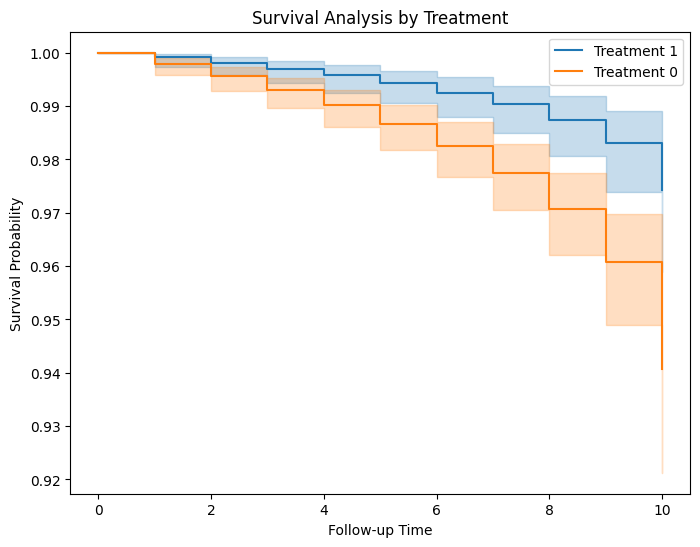

In [10]:
# ## Step 8: Survival Analysis Visualization
kmf = KaplanMeierFitter()
plt.figure(figsize=(8,6))
for t in trial_pp['treatment'].unique():
    subset = trial_pp[trial_pp['treatment'] == t]
    kmf.fit(subset['period'], event_observed=subset['outcome'])
    kmf.plot(label=f"Treatment {t}")
plt.xlabel("Follow-up Time")
plt.ylabel("Survival Probability")
plt.title("Survival Analysis by Treatment")
plt.legend()
plt.show()